In [1]:
import networkx as nx # make sure you installed networkx
import pandas as pd
import numpy as np

# Graph including only positive corsi influences
# Read in data
df = pd.read_csv("../../data/forwards/forwards_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','cf_inf_on1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)


# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# NOTE: this uses data calculated in defense-overall.ipynb
# average corsi influence
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_corsi_influence"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_corsi_influence")


In [2]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

Number of nodes:  758
Number of edges:  4442


In [3]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
greedy_communities = nxc.greedy_modularity_communities(G, weight='weight')

# add community info to node attributes
i = 0
greedy_communities_dict = dict.fromkeys(G.nodes)
for community in greedy_communities:
    for player in community:
        greedy_communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, greedy_communities_dict, "greedy_community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'forwards-positive.gexf')

In [10]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)

# Remove players with less than 20 games to clean up playerbase data a bit
players_df_pared = players_df.drop(players_df[players_df.games_played < 20].index)

In [11]:
def plot_distributions(stat):
    # Plot distribution of entire playerbase
    playerbase_stats = players_df_pared[stat].values
    print("n: ", len(playerbase_stats))
    print("mean: ", np.nanmean(playerbase_stats))
    print("std dev: ",np.nanstd(playerbase_stats))
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot distribution of each community individually
    i = 0
    for community in greedy_communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print("n: ", len(players_stats))
        print("mean: ", np.mean(players_stats))
        print("std dev: ",np.std(players_stats))
        plt.hist(players_stats, bins)
        plt.xlabel(stat)
        plt.ylabel("Count")
        title = "Community: " + str(i)
        plt.title(title)
        plt.show()
        i += 1

n:  1072
mean:  0.4865493595815173
std dev:  0.0381368673521429


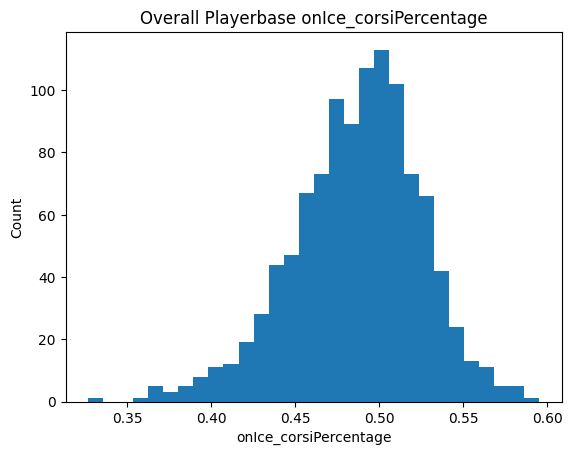

n:  66
mean:  0.4874437685894491
std dev:  0.024866467630856263


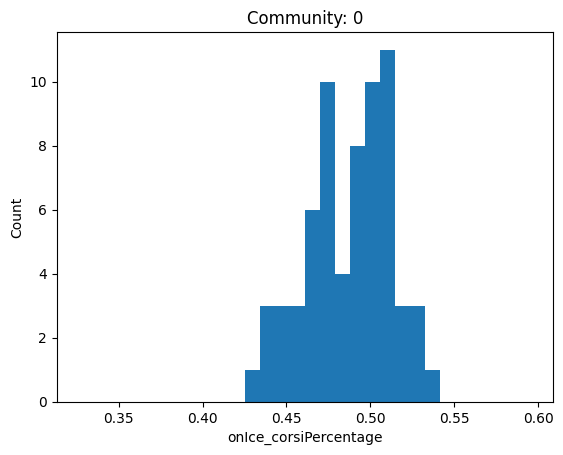

n:  63
mean:  0.5062829797350847
std dev:  0.02952885594848233


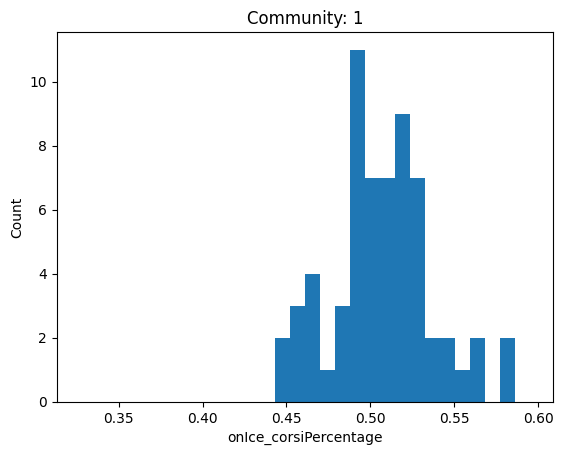

n:  57
mean:  0.4889910200507862
std dev:  0.02595912960910016


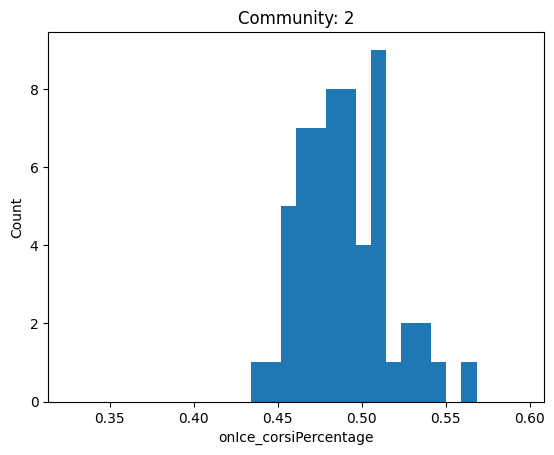

n:  56
mean:  0.4912060825140223
std dev:  0.026918436073314497


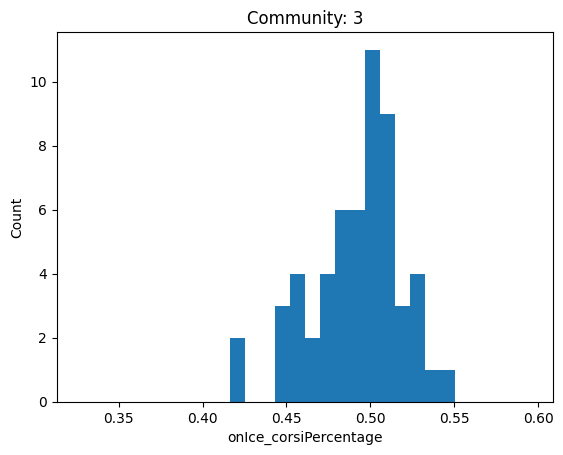

n:  55
mean:  0.49732798407169554
std dev:  0.03153609930743365


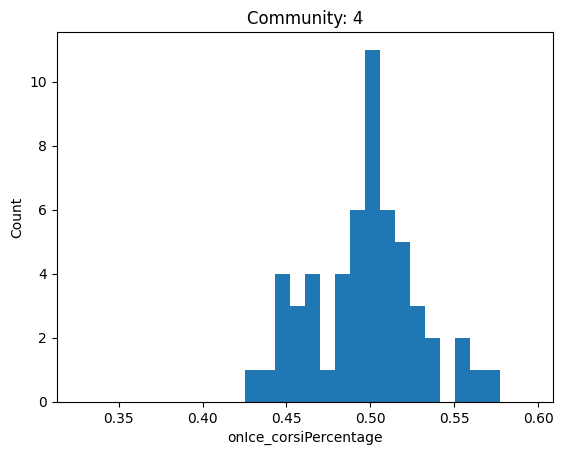

n:  54
mean:  0.4934685481928597
std dev:  0.033942723406738935


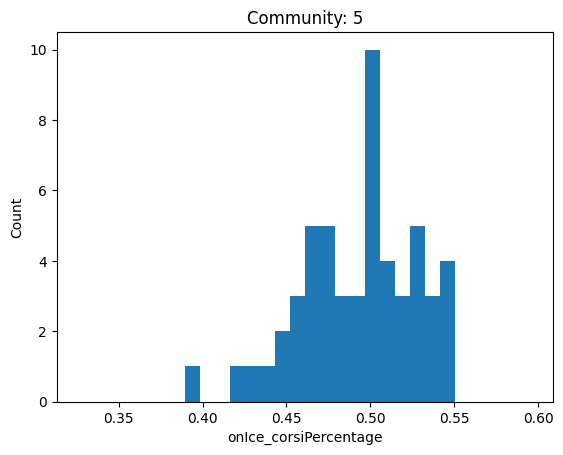

n:  51
mean:  0.49488500992413675
std dev:  0.03466446595184713


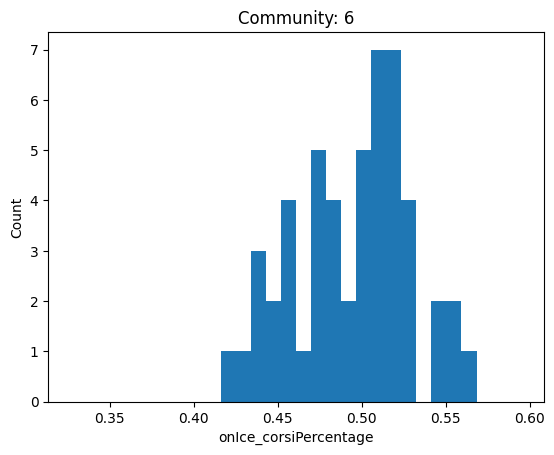

n:  50
mean:  0.49235217168125606
std dev:  0.03594546060767132


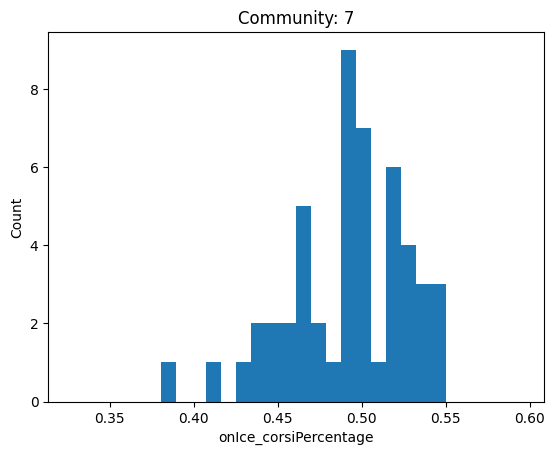

n:  45
mean:  0.48644304911969777
std dev:  0.029536693505969852


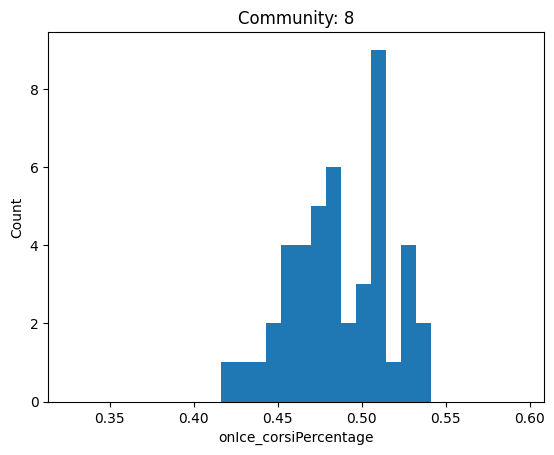

n:  39
mean:  0.491124651398802
std dev:  0.02988086289036685


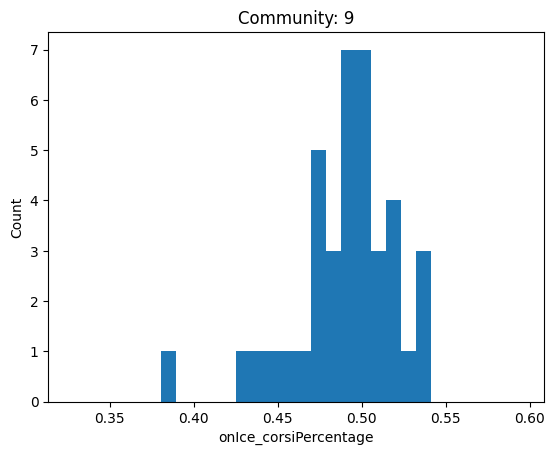

n:  38
mean:  0.5090006812083461
std dev:  0.027833436865553247


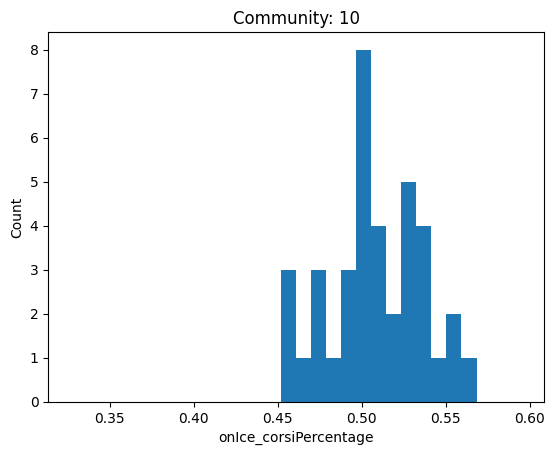

n:  37
mean:  0.5072839956016264
std dev:  0.0392338344923821


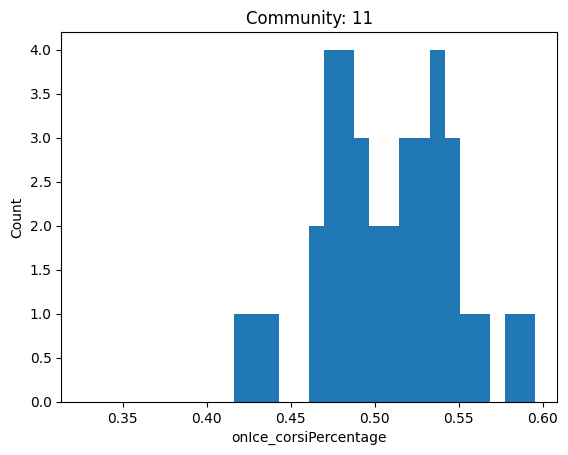

n:  36
mean:  0.5095957989697538
std dev:  0.030358183897590103


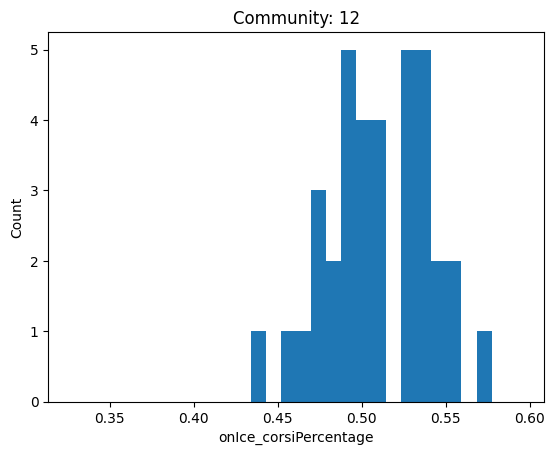

n:  28
mean:  0.49765526758313444
std dev:  0.023716727285561373


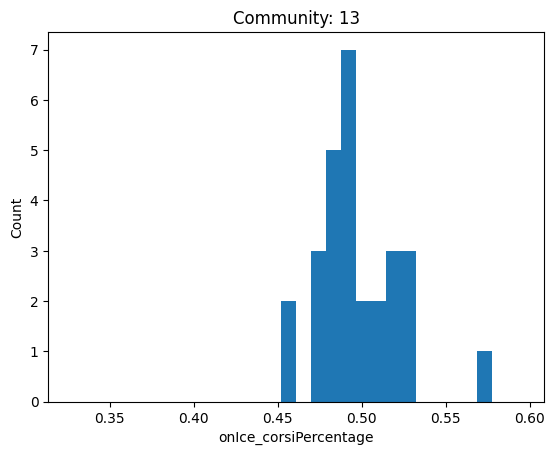

n:  27
mean:  0.4914946267618486
std dev:  0.026513847544163704


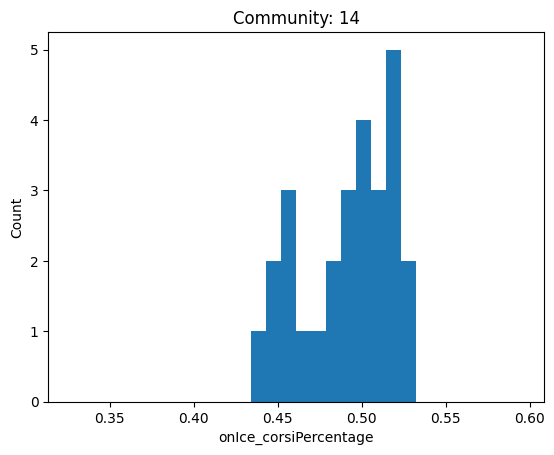

n:  19
mean:  0.5130261549777227
std dev:  0.030859035690747487


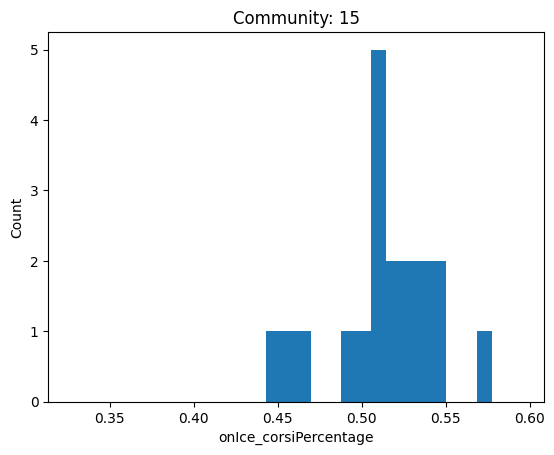

n:  17
mean:  0.4920124233144404
std dev:  0.0271270239219662


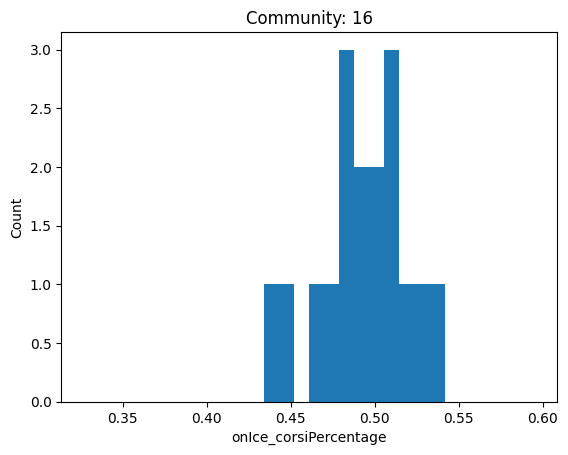

n:  9
mean:  0.4749771412877853
std dev:  0.028786035779628825


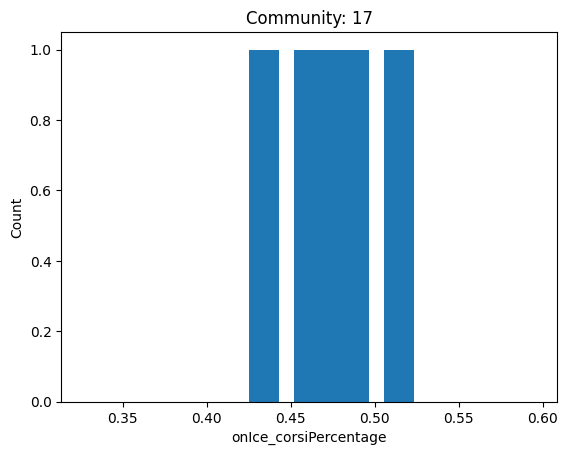

n:  8
mean:  0.4706740219468132
std dev:  0.022801343987381744


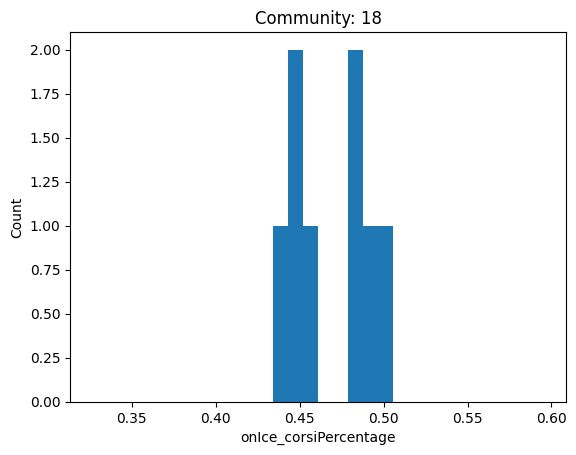

n:  3
mean:  0.49155706560487644
std dev:  0.0119322202610522


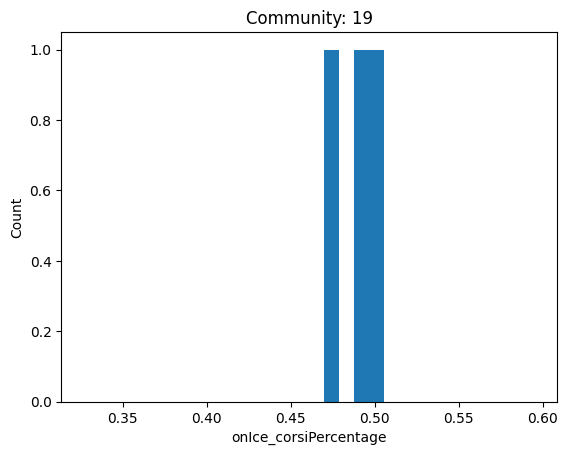

In [12]:
# Plot corsi influence distribution of entire playerbase
plot_distributions("onIce_corsiPercentage")
